# --- Sentiment Analysis of #DhoniRetires Tweets ---

## --- Phase 1: Setup and Data Loading ---

In [373]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [374]:
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

In [375]:
df = pd.read_csv('dhoniretires_tweets.csv')

In [376]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Ravi Shastry,All 3 places possible,"Tracer bullet on TV, Enfield Bullet in life. W...",03-04-2015 14:15,578,66,86,False,17-08-2020 10:54,I interacted with him as a commentator &amp; a...,NaN,Twitter for iPhone,False
1,India Today Sports,"Noida, India","Live cricket scores, news, analysis and fun fa...",26-09-2017 10:57,6434,15,10,False,17-08-2020 10:53,"""I don't see myself travelling for cricket aga...",NaN,Twitter Web App,False
2,Augmont Gold,Mumbai,"With Augmont Gold, you can now invest in as lo...",12-06-2012 12:10,2112,12,17,False,17-08-2020 10:52,You will never retire from our hearts!\n\n#Aug...,"['AugmontGold', 'TrendingFormats', 'MomentMark...",Twitter Web App,False
3,Papa Louie's pizza,NaN,NaN,18-07-2020 05:36,1,0,0,False,17-08-2020 10:51,From winning trophies 🏆 to winning people's he...,"['ThankYouDhoni', 'MSDhoni', 'Dhoni', 'Dhoni07...",Twitter for Android,False
4,🇮🇳 पंडित जीवेश मिश्रा 🇮🇳,JAUNPUR UP INDIA 🇮🇳🇮🇳,👍 सत्य बोलने के लिए किसी के आदेश की जरूरत नहीं...,01-08-2017 17:24,91,86,25251,False,17-08-2020 10:49,There's no limit to the creativity of some of ...,['DhoniRetires'],Twitter for Android,False


In [377]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         7500 non-null   object
 1   user_location     5468 non-null   object
 2   user_description  6598 non-null   object
 3   user_created      7500 non-null   object
 4   user_followers    7500 non-null   int64 
 5   user_friends      7500 non-null   int64 
 6   user_favourites   7500 non-null   int64 
 7   user_verified     7500 non-null   bool  
 8   date              7500 non-null   object
 9   text              7500 non-null   object
 10  hashtags          4988 non-null   object
 11  source            7500 non-null   object
 12  is_retweet        7500 non-null   bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 659.3+ KB


In [379]:
df.shape

(7500, 13)

## --- Phase 2: Data Exploration and Preprocessing ---

In [380]:
# Initialize lemmatizer and get English stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [381]:
custom_stopwords = [
    'dhoni', 'msdhoni', 'mahi', 'ms', 'thala', 'retires', 'retirement',
    'dhoniretires', 'cricket', 'indian', 'team', 'india', 'amp'
]
stop_words.update(custom_stopwords)
print(f"Custom stopwords added: {custom_stopwords}")

Custom stopwords added: ['dhoni', 'msdhoni', 'mahi', 'ms', 'thala', 'retires', 'retirement', 'dhoniretires', 'cricket', 'indian', 'team', 'india', 'amp']


In [382]:
def preprocess_tweet(text):
    """
    Cleans and preprocesses a single tweet.
    """
    if not isinstance(text, str):
        return ""
    
    # Remove "RT", URLs, and user mentions
    text = re.sub(r'RT\s+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (punctuation, numbers, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize, remove stop words, and lemmatize
    tokens = text.split()
    processed_tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words and len(word) > 2  # Keep words with more than 2 chars
    ]
    
    return " ".join(processed_tokens)

In [383]:
# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_tweet)

In [384]:
# Display original vs. processed text for comparison
print("\n--- Original vs. Processed Text Examples ---")
print(df[['text', 'processed_text']].head())


--- Original vs. Processed Text Examples ---
                                                text  \
0  I interacted with him as a commentator &amp; a...   
1  "I don't see myself travelling for cricket aga...   
2  You will never retire from our hearts!\n\n#Aug...   
3  From winning trophies 🏆 to winning people's he...   
4  There's no limit to the creativity of some of ...   

                                      processed_text  
0  interacted commentator coach never interfered ...  
1   dont see travelling around loved loved back paki  
2  never retire heart augmontgold trendingformats...  
3  winning trophy winning people heart thankyoudh...  
4        there limit creativity tribute suresh raina  


## --- Phase 3: Sentiment Analysis with VADER ---

In [385]:
# Initialize VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each processed tweet
df['sentiment_scores'] = df['processed_text'].apply(lambda text: sid.polarity_scores(text))

# Extract the compound score, a single metric for overall sentiment
df['compound_score'] = df['sentiment_scores'].apply(lambda d: d['compound'])

# Classify sentiment based on the compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound_score'].apply(classify_sentiment)

In [386]:
# Display tweets with their classified sentiment
print("\n--- Tweets with Classified Sentiment ---")
print(df[['text', 'sentiment', 'compound_score']].head())


--- Tweets with Classified Sentiment ---
                                                text sentiment  compound_score
0  I interacted with him as a commentator &amp; a...   Neutral          0.0000
1  "I don't see myself travelling for cricket aga...  Positive          0.8316
2  You will never retire from our hearts!\n\n#Aug...   Neutral          0.0000
3  From winning trophies 🏆 to winning people's he...  Positive          0.7783
4  There's no limit to the creativity of some of ...  Positive          0.3818


## --- Phase 4: Visualization and Insights ---

In [387]:
# --- 1. Overall Sentiment Distribution ---
sentiment_counts = df['sentiment'].value_counts()
print("\nOverall Sentiment Counts:")
print(sentiment_counts)


Overall Sentiment Counts:
sentiment
Positive    4092
Neutral     2320
Negative    1088
Name: count, dtype: int64


Text(0, 0.5, 'Number of Tweets')

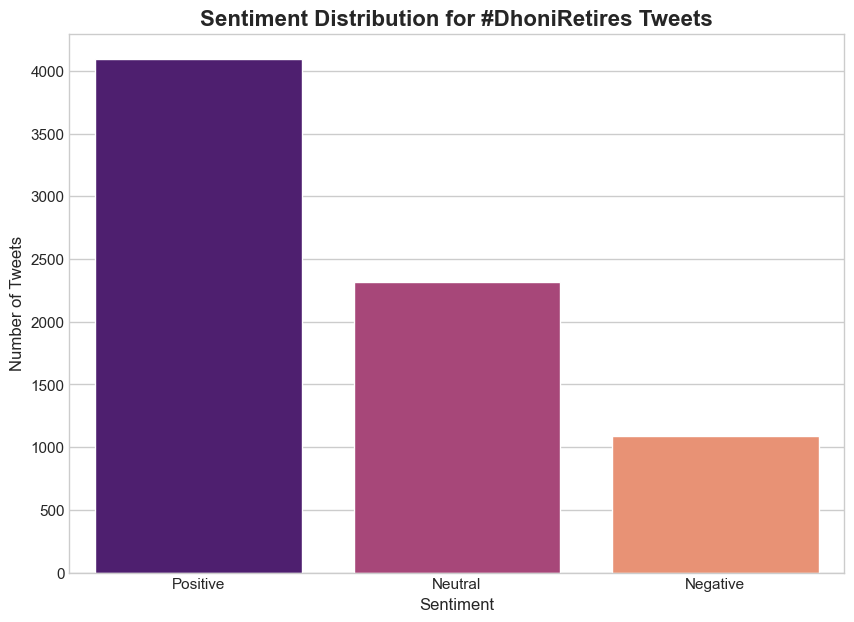

In [388]:
plt.figure(figsize=(10, 7))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='magma', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution for #DhoniRetires Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

In [389]:
# --- 2. Word Clouds for Positive and Negative Sentiments ---
positive_text = " ".join(df[df['sentiment'] == 'Positive']['processed_text'])
negative_text = " ".join(df[df['sentiment'] == 'Negative']['processed_text'])

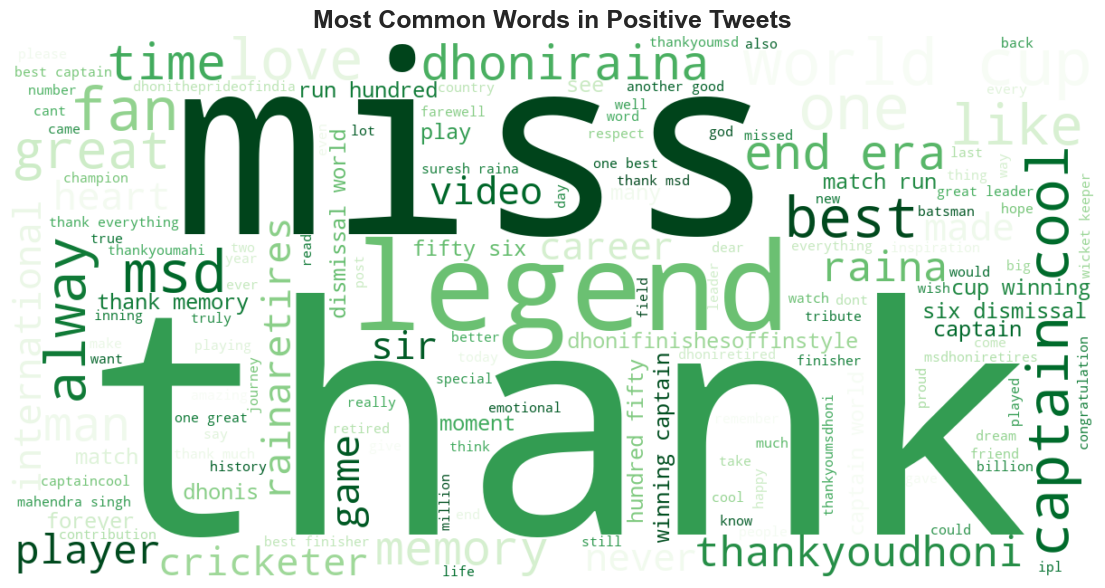

In [390]:
# Positive Word Cloud
if positive_text:
    plt.figure(figsize=(14, 8))
    wordcloud_pos = WordCloud(
        stopwords=stop_words,
        background_color='white',
        colormap='Greens',
        max_words=150,
        width=1200,
        height=600
    ).generate(positive_text)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Positive Tweets', fontsize=18, fontweight='bold')

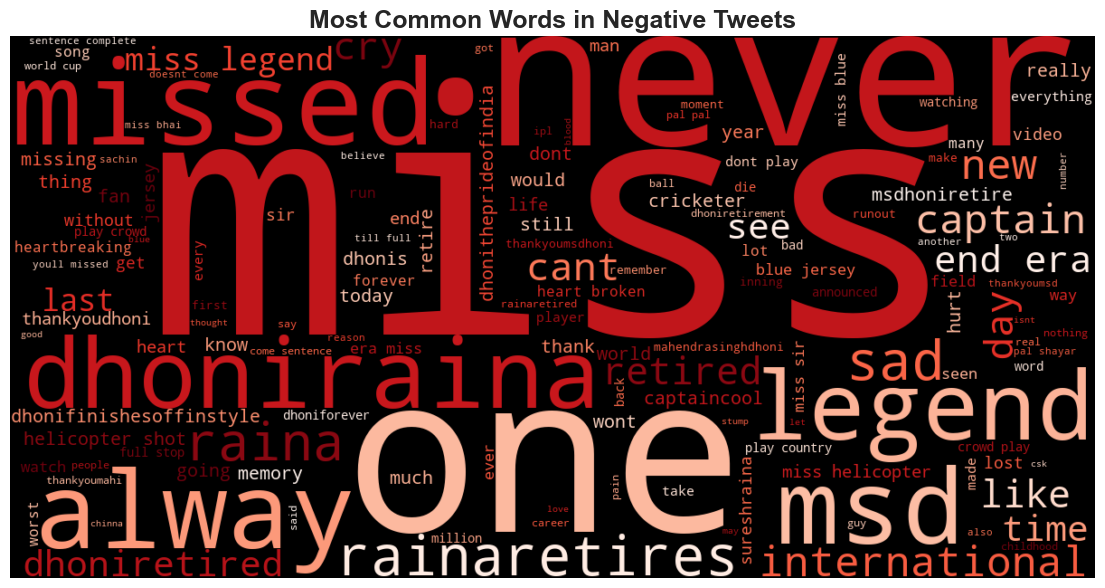

In [391]:
# Negative Word Cloud
if negative_text:
    plt.figure(figsize=(14, 8))
    wordcloud_neg = WordCloud(
        stopwords=stop_words,
        background_color='black',
        colormap='Reds',
        max_words=150,
        width=1200,
        height=600
    ).generate(negative_text)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Negative Tweets', fontsize=18, fontweight='bold')

## --- Phase 5: Time-Series Analysis of Sentiment ---

In [392]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

In [393]:
# Resample by hour to see the evolution of sentiment
hourly_sentiment = df.set_index('date')['compound_score'].resample('H').mean().dropna()

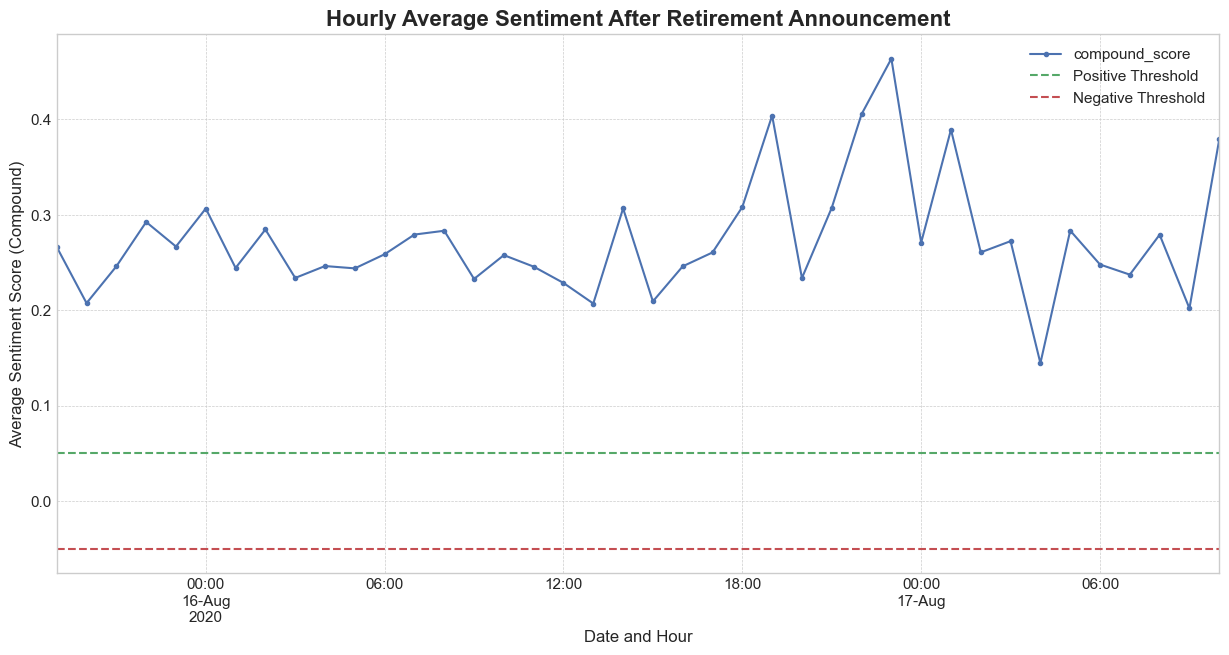

In [394]:
plt.figure(figsize=(15, 7))
hourly_sentiment.plot(kind='line', marker='.', linestyle='-')
plt.title('Hourly Average Sentiment After Retirement Announcement', fontsize=16, fontweight='bold')
plt.xlabel('Date and Hour', fontsize=12)
plt.ylabel('Average Sentiment Score (Compound)', fontsize=12)
plt.axhline(y=0.05, color='g', linestyle='--', label='Positive Threshold')
plt.axhline(y=-0.05, color='r', linestyle='--', label='Negative Threshold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [395]:
print("\n\n--- Analysis Complete ---")



--- Analysis Complete ---
